In [93]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import HistGradientBoostingRegressor as hgbr
from sklearn.neural_network import MLPRegressor as nn
from sklearn.linear_model import LinearRegression as ols
import sklearn.metrics as metrics
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import (StandardScaler, OneHotEncoder)
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

from panelsplit.cross_validation import PanelSplit
from panelsplit.application import cross_val_fit
from panelsplit.plot import plot_splits
from panelsplit.pipeline import SequentialCVPipeline

from scipy.stats import uniform, randint
import eli5
import shap
import warnings
warnings.filterwarnings('ignore')
# https://www.youtube.com/watch?v=-5l3g91NZfQ

In [2]:
# Define a utility function to take CV models and average them to output an ensemble
def extract_cv_fit(fit, X):
    predicts = [m.predict(X) for m in fit]
    mean = np.mean(predicts, axis=0)
    # create a DataFrame to hold both the mean and the individual predictions
    df = pd.DataFrame(predicts).T
    df.columns = [f'pred_{i+1}' for i in range(len(predicts))]
    df['pred_mean'] = mean

    return df

In [ ]:
reg_data = pd.read_csv(r'../data/reg_data.csv')

In [4]:
def downcast(df, verbose = True):
    start_memory = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        dtype_name = df[col].dtype.name
        if dtype_name == "object":
            pass
        elif dtype_name == "bool":
            df[col] = df[col].astype("int8")
        elif dtype_name.startswith("int") or (df[col].round() == df[col]).all():
            df[col] = pd.to_numeric(df[col], downcast = "integer")
        else:
            df[col] = pd.to_numeric(df[col], downcast = "float")
    end_memory = df.memory_usage().sum() / 1024 ** 2

    if verbose:
        print("{:.1f}% compressed".format(100 * (start_memory - end_memory) / start_memory))

    return df

reg_data = downcast(reg_data, verbose = True)

55.2% compressed


In [5]:
reg_data

,ID,shop_id,item_id,item_category_id,ym,qty,qty_lag1,qty_lag2,qty_lag3,qty_lag4,...,price_mean_substitute_shop_1_pclag1,price_mean_substitute_shop_1_pclag2,price_mean_substitute_shop_1_pclag3,price_mean_substitute_shop_2_pclag1,price_mean_substitute_shop_2_pclag2,price_mean_substitute_shop_2_pclag3,price_mean_substitute_shop_3_pclag1,price_mean_substitute_shop_3_pclag2,price_mean_substitute_shop_3_pclag3,max_qty_ever
0,0,5,5037,19,516,0.0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3
1,0,5,5037,19,517,0.0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3
2,0,5,5037,19,518,0.0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3
3,0,5,5037,19,519,0.0,0,0,0,0,...,-0.055018,-0.055018,-0.055018,-0.112373,-0.112373,-0.112373,0.000000,0.000000,0.000000,3
4,0,5,5037,19,520,0.0,0,0,0,0,...,-0.123432,-0.171658,-0.171658,-0.139710,-0.236383,-0.236383,0.000000,0.000000,0.000000,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7496995,214199,45,969,37,546,0.0,0,0,0,0,...,-0.140188,-0.053548,-0.196604,0.025246,-0.156370,-0.102922,-0.065911,-0.212094,-0.252122,3
7496996,214199,45,969,37,547,0.0,0,0,0,0,...,0.113565,-0.042543,0.053936,-0.078268,-0.054998,-0.222399,0.042034,-0.026648,-0.178975,3
7496997,214199,45,969,37,548,0.0,0,0,0,0,...,0.160749,0.292569,0.111367,0.229774,0.133522,0.162139,0.209847,0.260703,0.177608,3
7496998,214199,45,969,37,549,0.0,0,0,0,0,...,0.051180,0.220156,0.358723,-0.049031,0.169478,0.077945,0.024800,0.239852,0.291969,3


In [6]:
# Recode the ym variable to an index
# Create a time trend variable from ym values
unique_ym = sorted(reg_data['ym'].unique())
ym_to_trend = {ym: i for i, ym in enumerate(unique_ym)}
reg_data['month'] = reg_data['ym'].map(ym_to_trend)


In [ ]:
# Declare some variables as categorical
reg_data['shop_id']          = reg_data['shop_id'].astype('category')
reg_data['item_id']          = reg_data['item_id'].astype('category')
reg_data['item_category_id'] = reg_data['item_category_id'].astype('category')

# month of year
reg_data['month_of_year'] = reg_data['month'].mod(12)
reg_data['month_of_year'] = reg_data['month_of_year'].astype('category')

In [8]:
# Clipping variables: the test data has range (0,20)
vars_to_clip = ['qty', 'qty_lag1', 'qty_lag2', 'qty_lag3', 'qty_lag4', 'qty_lag5', 'qty_lag6', 'qty_roll3_lag1', 'qty_roll3_lag2', 'qty_roll3_lag3', 'qty_roll6_lag1', 'qty_roll6_lag2', 'qty_roll6_lag3', 'qty_roll12_lag1', 'qty_roll12_lag2', 'qty_roll12_lag3']

for var in vars_to_clip:
    # Clip the variable to the range (0, 20)
    reg_data[var].clip(0, 20, inplace=True)

C:\Users\Steven\AppData\Local\Temp\ipykernel_19076\1268739819.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  reg_data[var].clip(0, 20, inplace=True)
C:\Users\Steven\AppData\Local\Temp\ipykernel_19076\1268739819.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, w

In [9]:
# One-hot encode categorical variables
item_category = pd.get_dummies(reg_data['item_category_id'], prefix='item_category', dtype=np.int8)
stores = pd.get_dummies(reg_data['shop_id'], prefix='shop', dtype=np.int8)
months = pd.get_dummies(reg_data['month_of_year'], prefix='month', dtype=np.int8)

# Combine the one-hot encoded variables with the original DataFrame
reg_data = pd.concat([reg_data, item_category, stores, months], axis=1)
reg_data

,ID,shop_id,item_id,item_category_id,ym,qty,qty_lag1,qty_lag2,qty_lag3,qty_lag4,...,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11
0,0,5,5037,19,516,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,5,5037,19,517,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,5,5037,19,518,0.0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0,5,5037,19,519,0.0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0,5,5037,19,520,0.0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7496995,214199,45,969,37,546,0.0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
7496996,214199,45,969,37,547,0.0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
7496997,214199,45,969,37,548,0.0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
7496998,214199,45,969,37,549,0.0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [10]:
# Final Test data is where month == 34 (2015 Nov)
test_2015_nov = reg_data[reg_data['month'] == 34]
reg_data = reg_data[reg_data['month'] != 34]
reg_data = reg_data[reg_data['month'] > 3] # chopping the data
reg_data.index = range(len(reg_data))

test_2015_oct = reg_data[reg_data['month'] == 33]
train_data = reg_data[reg_data['month'] != 33]

In [14]:
cols = ""
for c in train_data.columns:
    cols += "'" + c + "', "
cols = cols[:-2]  # remove last comma and space
print(cols)

'ID', 'shop_id', 'item_id', 'item_category_id', 'ym', 'qty', 'qty_lag1', 'qty_lag2', 'qty_lag3', 'qty_lag4', 'qty_lag5', 'qty_lag6', 'qty_roll3_lag1', 'qty_roll3_lag2', 'qty_roll3_lag3', 'qty_roll6_lag1', 'qty_roll6_lag2', 'qty_roll6_lag3', 'qty_roll12_lag1', 'qty_roll12_lag2', 'qty_roll12_lag3', 'relative_price_lag1', 'relative_price_lag2', 'relative_price_lag3', 'relative_price_lag4', 'relative_price_lag5', 'relative_price_lag6', 'relative_price3_lag1', 'relative_price3_lag2', 'relative_price3_lag3', 'product_qty_pclag1', 'product_qty_pclag2', 'product_qty_pclag3', 'shop_qty_pclag1', 'shop_qty_pclag2', 'shop_qty_pclag3', 'qty_substitute_prod_pclag1', 'qty_substitute_prod_pclag2', 'qty_substitute_prod_pclag3', 'price_mean_complement_prod_1_pclag1', 'price_mean_complement_prod_1_pclag2', 'price_mean_complement_prod_1_pclag3', 'price_mean_complement_prod_2_pclag1', 'price_mean_complement_prod_2_pclag2', 'price_mean_complement_prod_2_pclag3', 'price_mean_complement_prod_3_pclag1', 'price

In [15]:
Xcols = [
    'qty_lag1', 'qty_lag2', 'qty_lag3', 'qty_lag4', 'qty_lag5', 'qty_lag6', 'qty_roll3_lag1', 'qty_roll3_lag2', 'qty_roll3_lag3', 'qty_roll6_lag1', 'qty_roll6_lag2', 'qty_roll6_lag3', 'qty_roll12_lag1', 'qty_roll12_lag2', 'qty_roll12_lag3', 'relative_price_lag1', 'relative_price_lag2', 'relative_price_lag3', 'relative_price_lag4', 'relative_price_lag5', 'relative_price_lag6', 'relative_price3_lag1', 'relative_price3_lag2', 'relative_price3_lag3', 'product_qty_pclag1', 'product_qty_pclag2', 'product_qty_pclag3', 'shop_qty_pclag1', 'shop_qty_pclag2', 'shop_qty_pclag3', 'qty_substitute_prod_pclag1', 'qty_substitute_prod_pclag2', 'qty_substitute_prod_pclag3', 'price_mean_complement_prod_1_pclag1', 'price_mean_complement_prod_1_pclag2', 'price_mean_complement_prod_1_pclag3', 'price_mean_complement_prod_2_pclag1', 'price_mean_complement_prod_2_pclag2', 'price_mean_complement_prod_2_pclag3', 'price_mean_complement_prod_3_pclag1', 'price_mean_complement_prod_3_pclag2', 'price_mean_complement_prod_3_pclag3', 'price_mean_substitute_shop_1_pclag1', 'price_mean_substitute_shop_1_pclag2', 'price_mean_substitute_shop_1_pclag3', 'price_mean_substitute_shop_2_pclag1', 'price_mean_substitute_shop_2_pclag2', 'price_mean_substitute_shop_2_pclag3', 'price_mean_substitute_shop_3_pclag1', 'price_mean_substitute_shop_3_pclag2', 'price_mean_substitute_shop_3_pclag3', 
    'month', 'item_category_id', 'shop_id', 'month_of_year'
]

In [18]:
for i in Xcols:
    print(f"{i}: {reg_data[i].dtype}")
    

qty_lag1: int16
qty_lag2: int16
qty_lag3: int16
qty_lag4: int16
qty_lag5: int16
qty_lag6: int16
qty_roll3_lag1: float32
qty_roll3_lag2: float32
qty_roll3_lag3: float32
qty_roll6_lag1: float32
qty_roll6_lag2: float32
qty_roll6_lag3: float32
qty_roll12_lag1: float32
qty_roll12_lag2: float32
qty_roll12_lag3: float32
relative_price_lag1: float32
relative_price_lag2: float32
relative_price_lag3: float32
relative_price_lag4: float32
relative_price_lag5: float32
relative_price_lag6: float32
relative_price3_lag1: float32
relative_price3_lag2: float32
relative_price3_lag3: float32
product_qty_pclag1: float32
product_qty_pclag2: float32
product_qty_pclag3: float32
shop_qty_pclag1: float32
shop_qty_pclag2: float32
shop_qty_pclag3: float32
qty_substitute_prod_pclag1: float32
qty_substitute_prod_pclag2: float32
qty_substitute_prod_pclag3: float32
price_mean_complement_prod_1_pclag1: float32
price_mean_complement_prod_1_pclag2: float32
price_mean_complement_prod_1_pclag3: float32
price_mean_compleme

In [19]:
reg_data.drop(columns=['item_category_0', 'item_category_2', 'item_category_3', 'item_category_5', 'item_category_6', 'item_category_7', 'item_category_9', 'item_category_11', 'item_category_12', 'item_category_15', 'item_category_16', 'item_category_19', 'item_category_20', 'item_category_21', 'item_category_22', 'item_category_23', 'item_category_24', 'item_category_25', 'item_category_26', 'item_category_27', 'item_category_28', 'item_category_29', 'item_category_30', 'item_category_31', 'item_category_33', 'item_category_34', 'item_category_35', 'item_category_36', 'item_category_37', 'item_category_38', 'item_category_40', 'item_category_41', 'item_category_42', 'item_category_43', 'item_category_44', 'item_category_45', 'item_category_47', 'item_category_49', 'item_category_54', 'item_category_55', 'item_category_56', 'item_category_57', 'item_category_58', 'item_category_60', 'item_category_61', 'item_category_62', 'item_category_63', 'item_category_64', 'item_category_65', 'item_category_67', 'item_category_69', 'item_category_70', 'item_category_71', 'item_category_72', 'item_category_73', 'item_category_74', 'item_category_75', 'item_category_76', 'item_category_77', 'item_category_78', 'item_category_79', 'item_category_83', 'shop_2', 'shop_3', 'shop_4', 'shop_5', 'shop_6', 'shop_7', 'shop_10', 'shop_12', 'shop_14', 'shop_15', 'shop_16', 'shop_18', 'shop_19', 'shop_21', 'shop_22', 'shop_24', 'shop_25', 'shop_26', 'shop_28', 'shop_31', 'shop_34', 'shop_35', 'shop_36', 'shop_37', 'shop_38', 'shop_39', 'shop_41', 'shop_42', 'shop_44', 'shop_45', 'shop_46', 'shop_47', 'shop_48', 'shop_49', 'shop_50', 'shop_52', 'shop_53', 'shop_55', 'shop_56', 'shop_57', 'shop_58', 'shop_59', 'month_0', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11'], inplace=True)

In [20]:
len(Xcols)

55

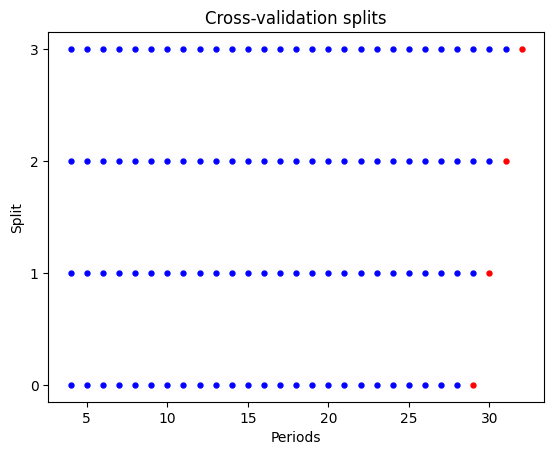

In [116]:
mycv  = PanelSplit(periods = train_data.month, n_splits = 4, gap = 0, test_size=1)
plot_splits(mycv)

In [ ]:
splits=2

mycv = PanelSplit(periods = train_data.month, n_splits = splits, gap = 0, test_size=1)

model = hgbr(
    categorical_features='from_dtype',
    max_iter=1000,
    max_depth=None,
    max_leaf_nodes=500,
    min_samples_leaf=1000,
    learning_rate=0.1, # default is 0.1
    l2_regularization=0.2,
    max_features=0.75,
    early_stopping=True,
    validation_fraction=0.2,
    scoring='neg_root_mean_squared_error',
    verbose=2
)

pipeline = Pipeline([
     ('scaler', StandardScaler()),
 #    ('pca', PCA(n_components=0.95)),
     ('model', model)
 ], verbose=True)

fit = cross_val_fit(pipeline, reg_data[Xcols], reg_data['qty'], mycv, n_jobs=1)

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   7.0s
Binning 2.262 GB of training data: 2.135 s
Binning 0.565 GB of validation data: 0.541 s
Fitting gradient boosted rounds:
[1/1000] 1 tree, 500 leaves, max depth = 22, train score: -0.98829, val score: -1.00887, in 1.562s
[2/1000] 1 tree, 500 leaves, max depth = 21, train score: -0.93476, val score: -0.95580, in 1.327s
[3/1000] 1 tree, 500 leaves, max depth = 20, train score: -0.89048, val score: -0.90966, in 1.188s
[4/1000] 1 tree, 500 leaves, max depth = 18, train score: -0.85156, val score: -0.87038, in 1.243s
[5/1000] 1 tree, 500 leaves, max depth = 20, train score: -0.81849, val score: -0.83619, in 1.333s
[6/1000] 1 tree, 500 leaves, max depth = 23, train score: -0.78872, val score: -0.80695, in 1.243s
[7/1000] 1 tree, 500 leaves, max depth = 21, train score: -0.76402, val score: -0.78161, in 1.182s
[8/1000] 1 tree, 500 leaves, max depth = 22, train score: -0.74279, val score: -0.76036, in 1.229s
[9/1000] 1 tree,

ValueError: Found array with 0 sample(s) (shape=(0, 55)) while a minimum of 1 is required by StandardScaler.

In [87]:
fit[1]

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 HistGradientBoostingRegressor(early_stopping=True,
                                               l2_regularization=0.2,
                                               max_features=0.75, max_iter=1000,
                                               max_leaf_nodes=500,
                                               min_samples_leaf=1000,
                                               scoring='neg_root_mean_squared_error',
                                               validation_fraction=0.2,
                                               verbose=2))],
         verbose=True)

In [88]:
predictions = extract_cv_fit(fit, test_2015_nov[Xcols])

AttributeError: 'StandardScaler' object has no attribute 'predict'

In [80]:
predictions

,pred_1,pred_2,pred_mean
0,0.840375,0.676299,0.758337
1,0.006494,0.001607,0.004051
2,0.926786,0.890685,0.908735
3,0.079581,0.124352,0.101966
4,0.005684,-0.001169,0.002258
...,...,...,...
214195,0.256161,0.349776,0.302968
214196,0.004187,0.000029,0.002108
214197,0.016426,0.001996,0.009211
214198,0.004740,0.000034,0.002387


In [89]:
# Export post-processed prediction
testresults = test_2015_nov
testresults.index = range(len(testresults))
testresults['item_cnt_month'] = predictions['pred_2']

testresults['item_cnt_month'].clip(0, 20, inplace=True)

to_export = testresults[['ID', 'item_cnt_month']]
to_export.to_csv(r'../output/predictions_gbm_202505081000.csv', index=False)

C:\Users\Steven\AppData\Local\Temp\ipykernel_21744\1062753260.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testresults['item_cnt_month'] = predictions['pred_2']
C:\Users\Steven\AppData\Local\Temp\ipykernel_21744\1062753260.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  testre

In [85]:
# Export post-processed prediction
testresults = test_2015_nov
testresults.index = range(len(testresults))
testresults['item_cnt_month'] = predictions['pred_mean']
testresults = testresults[['ID', 'qty_lag1', 'qty_lag2', 'qty_lag3', 'qty_roll3_lag1', 'max_qty_ever', 'ym', 'item_cnt_month']]

# Rules for recent zero sales:
# 1. If the last 3 months of sales is zero (not brand new), set to 0
testresults.loc[
    (testresults['qty_lag1'] == 0) & 
    (testresults['qty_lag2'] == 0) & 
    (testresults['qty_lag3'] == 0) &
    (testresults['max_qty_ever'] > 0)
    , 'item_cnt_month'] = 0
# 2. If the last month of sales is zero but the last 3 months is non-zero, set to qty_roll3_lag1
testresults.loc[
    (testresults['qty_lag1'] == 0) & 
    (testresults['qty_roll3_lag1'] > 0) & 
    (testresults['max_qty_ever'] > 0)
    , 'item_cnt_month'] = testresults['qty_roll3_lag1']

# Clipping
#testresults.loc[(testresults['qty_lag1'] > 0) & (testresults['item_cnt_month'] == 0), 'item_cnt_month'] = 1
#testresults.loc[(testresults['max_qty_ever'] > 0) & (testresults['item_cnt_month'] > testresults['max_qty_ever']), 'item_cnt_month'] = testresults['max_qty_ever']
testresults['item_cnt_month'].clip(0, 20, inplace=True)

to_export = testresults[['ID', 'item_cnt_month']]
to_export.to_csv(r'../output/predictions_gbm_202505080953_post.csv', index=False)

C:\Users\Steven\AppData\Local\Temp\ipykernel_21744\1993675585.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testresults['item_cnt_month'] = predictions['pred_mean']
C:\Users\Steven\AppData\Local\Temp\ipykernel_21744\1993675585.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  te

In [82]:
to_export

,ID,item_cnt_month
0,0,0.758337
1,1,0.004051
2,2,0.908735
3,3,0.101966
4,4,0.002258
...,...,...
214195,214195,0.302968
214196,214196,0.002108
214197,214197,0.009211
214198,214198,0.002387


In [83]:
samp_train = shap.utils.sample(train_data[Xcols], 500)
samp_test = shap.utils.sample(test_2015_oct[Xcols], 500)

explainer = shap.TreeExplainer(fit[0][1],samp_train)
shap_values = explainer.shap_values(samp_test)


100%|===================| 499/500 [00:43<00:00]        

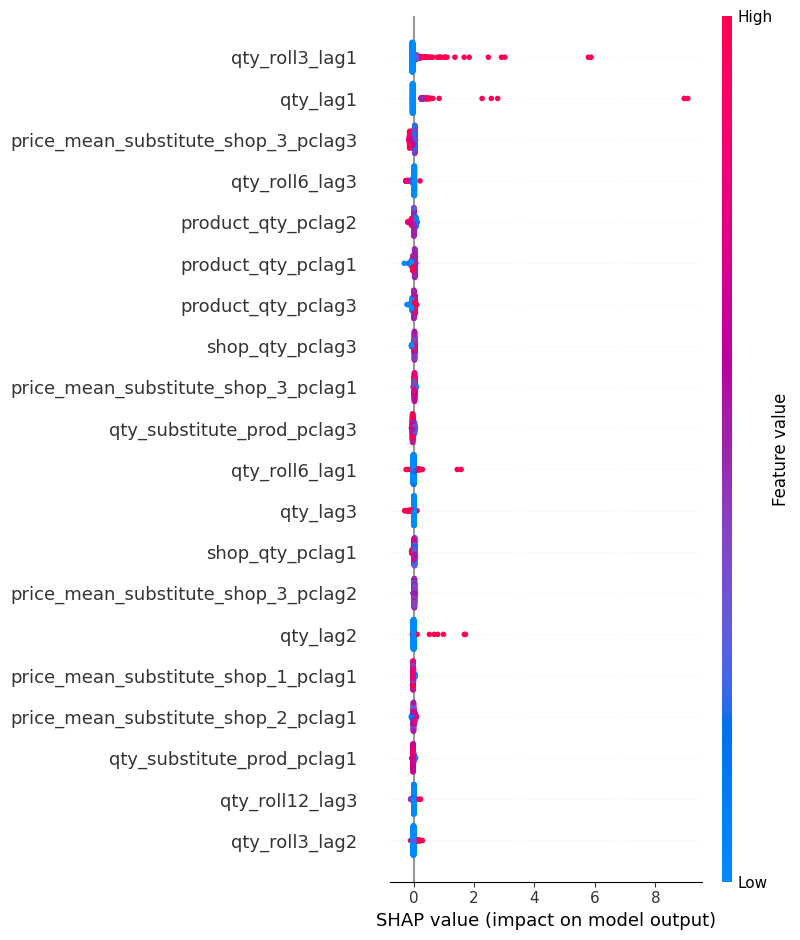

In [84]:
shap.summary_plot(shap_values,samp_test)

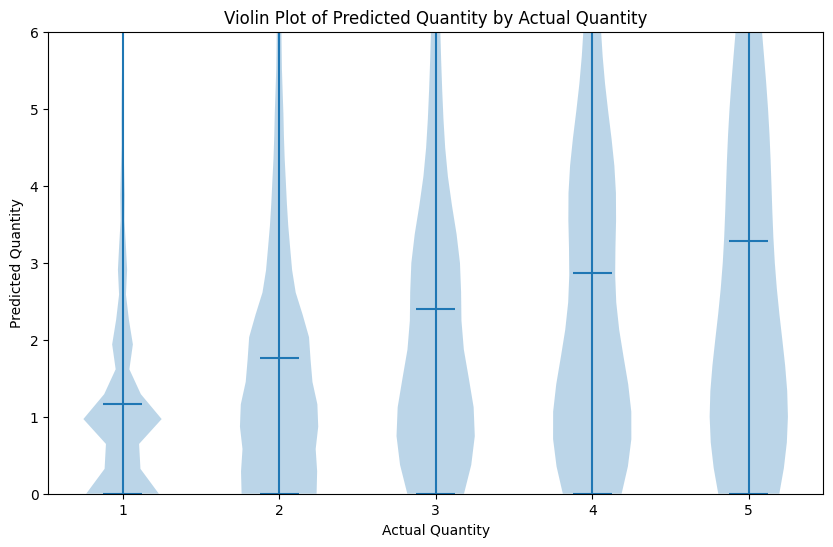

In [ ]:
# Add a violin plot of predicted values for y_test = 1, 2, 3, 4, and 5
plt.figure(figsize=(10, 6))
plt.violinplot([testresults[testresults['qty'] == i]['pred'] for i in range(1, 6)], showmeans=True)
plt.xticks([1, 2, 3, 4, 5], ['1', '2', '3', '4', '5'])
plt.xlabel('Actual Quantity')
plt.ylabel('Predicted Quantity')
plt.title('Violin Plot of Predicted Quantity by Actual Quantity')
ax = plt.gca()
ax.set_ylim([0, 6])
plt.show()

Below is hyperparameter tuning via randomized grid search.

We want to perform our grid search on small samples of the data, because it is so large that computation would be too slow.
I'd rather train on less data and test more hyperparameters than vice versa.

In [21]:
# Define a function to sample data by ID
def sample_id(df, p=0.01):
    ids = df['ID'].unique()
    # Sample IDs based on the given probability p
    sampled_ids = np.random.choice(ids, size=int(len(ids) * p), replace=False)
    # Filter the DataFrame to keep only the sampled IDs
    df = df[df['ID'].isin(sampled_ids)]
    
    # Reset the indices
    df.index = range(len(df))
    
    # Now return both X and y
    return df

In [213]:
# Declare hyperparameter grid for RandomizedSearchCV
# https://stackoverflow.com/questions/28178763/sklearn-use-pipeline-in-a-randomizedsearchcv
param_grid = {
    'model__max_depth': randint(10, 2000),
    'model__learning_rate': uniform(0.01, 0.2),
    'model__min_samples_leaf': randint(50, 1000),
    'model__max_features': uniform(0.1, 0.9),
    'model__l2_regularization': uniform(0, 0.5),
}

In [214]:
model = hgbr(
    categorical_features='from_dtype',
    max_iter=1000,
    n_iter_no_change=5,
    early_stopping=True,
    validation_fraction=0.2,
    scoring='neg_root_mean_squared_error',
    verbose=0
)

pipeline = Pipeline([
     ('scaler', StandardScaler()),
     ('model', model)
 ], verbose=False)

In [223]:
# Package everything into a function
def perform_CV(
        reg_data,
        Xcols,
        y_var,
        pipeline, 
        param_grid, 
        n_samples, 
        p,
        splits,
        n_cv_iter
        ):
    for i in range(n_samples):
        print(f'Current sample number: {i+1} of {n_samples}')

        df_samp = sample_id(reg_data, p=p)
        
        mycv = PanelSplit(periods = df_samp.month, n_splits = splits, gap = 0, test_size=1)
        search_initial = RandomizedSearchCV(
            pipeline,
            param_distributions=param_grid, 
            n_iter=n_cv_iter, 
            cv=mycv, 
            scoring='neg_root_mean_squared_error', 
            n_jobs=-1, # -1 uses all processors
            verbose=4)
        
        if i == 0:
            results = search_initial.fit(df_samp[Xcols], df_samp[y_var])
            data = results.cv_results_
            data['sample'] = [i]*n_cv_iter

        else:
            results = search_initial.fit(df_samp[Xcols], df_samp[y_var])
            for j in results.cv_results_:
                data[j] = np.append(data[j], results.cv_results_[j])
            data['sample'].extend([i]*n_cv_iter)

    return pd.DataFrame(data)

In [217]:
# running the function
df = perform_CV(
        reg_data=reg_data,
        Xcols=Xcols,
        y_var='qty',
        pipeline=pipeline, 
        param_grid=param_grid, 
        n_samples=10, 
        p=0.025,
        splits=2,
        n_cv_iter=100
        )

Current sample number: 1 of 10
Fitting 2 folds for each of 100 candidates, totalling 200 fits
Current sample number: 2 of 10
Fitting 2 folds for each of 100 candidates, totalling 200 fits
Current sample number: 3 of 10
Fitting 2 folds for each of 100 candidates, totalling 200 fits
Current sample number: 4 of 10
Fitting 2 folds for each of 100 candidates, totalling 200 fits
Current sample number: 5 of 10
Fitting 2 folds for each of 100 candidates, totalling 200 fits
Current sample number: 6 of 10
Fitting 2 folds for each of 100 candidates, totalling 200 fits
Current sample number: 7 of 10
Fitting 2 folds for each of 100 candidates, totalling 200 fits
Current sample number: 8 of 10
Fitting 2 folds for each of 100 candidates, totalling 200 fits
Current sample number: 9 of 10
Fitting 2 folds for each of 100 candidates, totalling 200 fits
Current sample number: 10 of 10
Fitting 2 folds for each of 100 candidates, totalling 200 fits


In [218]:
# Get the best model of all iterations
best_row = df[df['mean_test_score']==df['mean_test_score'].max()]
best_learning_rate = best_row['param_model__learning_rate'].values[0]
best_max_depth = best_row['param_model__max_depth'].values[0]
best_max_features = best_row['param_model__max_features'].values[0]
best_min_samples_leaf = best_row['param_model__min_samples_leaf'].values[0]
best_l2_regularization = best_row['param_model__l2_regularization'].values[0]

best_min_samples_leaf

np.int64(123)

In [219]:
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__l2_regularization,param_model__learning_rate,param_model__max_depth,param_model__max_features,param_model__min_samples_leaf,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score,sample
0,38.053654,7.005755,0.388133,0.069823,0.099409,0.105233,1816,0.382180,915,{'model__l2_regularization': 0.099409261689654...,-0.684920,-0.895320,-0.790120,0.105200,94,0
1,29.419154,4.452564,0.511742,0.090331,0.081518,0.173442,622,0.311428,646,{'model__l2_regularization': 0.081518389733535...,-0.663567,-0.886665,-0.775116,0.111549,61,0
2,27.416053,4.743822,0.398389,0.173641,0.346402,0.130255,1432,0.239505,702,{'model__l2_regularization': 0.346401740272113...,-0.667428,-0.885004,-0.776216,0.108788,65,0
3,4.233090,0.612474,0.037549,0.010524,0.415361,0.163951,306,0.860807,57,{'model__l2_regularization': 0.415361444590063...,-0.643018,-0.848342,-0.745680,0.102662,14,0
4,7.192726,2.667686,0.136893,0.104864,0.190565,0.164165,1951,0.623577,133,{'model__l2_regularization': 0.190565483407563...,-0.644429,-0.850675,-0.747552,0.103123,15,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,17.201467,0.129709,0.209980,0.035277,0.316706,0.187110,513,0.239823,922,{'model__l2_regularization': 0.316706394305598...,-0.830037,-0.799549,-0.814793,0.015244,80,9
996,36.927546,2.114173,0.372021,0.022140,0.480938,0.050075,1135,0.499206,941,{'model__l2_regularization': 0.480937852380620...,-0.842412,-0.798864,-0.820638,0.021774,92,9
997,36.071839,5.403010,0.471509,0.102876,0.340471,0.075517,1883,0.463566,907,{'model__l2_regularization': 0.340471307051700...,-0.830669,-0.797028,-0.813849,0.016821,76,9
998,30.439435,3.797266,0.400549,0.092333,0.267738,0.011446,1551,0.303178,231,{'model__l2_regularization': 0.267737718956404...,-0.831300,-0.748198,-0.789749,0.041551,45,9


In [225]:
# Secondary tuning, https://www.youtube.com/watch?v=-5l3g91NZfQ
param_grid = {
    'model__learning_rate': uniform(0.001, best_learning_rate),
}
model = hgbr(
    categorical_features='from_dtype',
    max_iter=5000,
    l2_regularization=best_l2_regularization,
    max_depth=best_max_depth,
    min_samples_leaf=best_min_samples_leaf,
    max_features=best_max_features,
    early_stopping=True,
    validation_fraction=0.2,
    scoring='neg_root_mean_squared_error',
    verbose=0
)

pipeline = Pipeline([
     ('scaler', StandardScaler()),
     ('model', model)
 ], verbose=True)

# running the function
df_secondary = perform_CV(
        reg_data=reg_data,
        Xcols=Xcols,
        y_var='qty',
        pipeline=pipeline, 
        param_grid=param_grid, 
        n_samples=10, 
        p=0.025,
        splits=2,
        n_cv_iter=25
        )

Current sample number: 1 of 10
Fitting 2 folds for each of 25 candidates, totalling 50 fits
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.2s
[Pipeline] ............. (step 2 of 2) Processing model, total=   4.9s
Current sample number: 2 of 10
Fitting 2 folds for each of 25 candidates, totalling 50 fits
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.1s
[Pipeline] ............. (step 2 of 2) Processing model, total=  29.1s
Current sample number: 3 of 10
Fitting 2 folds for each of 25 candidates, totalling 50 fits
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.2s
[Pipeline] ............. (step 2 of 2) Processing model, total=  27.6s
Current sample number: 4 of 10
Fitting 2 folds for each of 25 candidates, totalling 50 fits
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.1s
[Pipeline] ............. (step 2 of 2) Processing model, total=   3.5s
Current sample number: 5 of 10
Fitting 2 folds for each of 25 ca

In [226]:
df_secondary

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__learning_rate,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score,sample
0,28.525193,2.937470,0.457701,0.005243,0.036619,{'model__learning_rate': 0.03661936270486661},-0.754202,-0.840059,-0.797131,0.042928,10,0
1,38.797675,1.563761,0.533801,0.101884,0.023957,{'model__learning_rate': 0.02395680338678999},-0.755586,-0.842022,-0.798804,0.043218,17,0
2,27.330991,8.426135,0.373662,0.086370,0.035006,{'model__learning_rate': 0.03500604077851655},-0.755797,-0.840649,-0.798223,0.042426,13,0
3,22.284849,3.079634,0.324311,0.031537,0.050087,{'model__learning_rate': 0.050087310056162036},-0.762918,-0.830452,-0.796685,0.033767,8,0
4,25.876692,1.749639,0.419932,0.068063,0.032498,{'model__learning_rate': 0.03249838998617657},-0.755310,-0.836367,-0.795838,0.040528,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...
245,95.199021,10.342403,1.615691,0.265311,0.006820,{'model__learning_rate': 0.006819727519393844},-0.787852,-0.668616,-0.728234,0.059618,15,9
246,121.136264,7.819780,1.959915,0.409109,0.003616,{'model__learning_rate': 0.0036156643320645098},-0.784047,-0.668229,-0.726138,0.057909,9,9
247,34.278856,3.982412,0.507863,0.008358,0.023409,{'model__learning_rate': 0.02340853779017076},-0.784275,-0.668751,-0.726513,0.057762,12,9
248,28.546778,5.041999,0.454161,0.132694,0.026795,{'model__learning_rate': 0.026794796559663252},-0.782229,-0.669852,-0.726041,0.056189,8,9


In [227]:
# Get the best model of all iterations
best_row_secondary = df_secondary[df_secondary['mean_test_score']==df_secondary['mean_test_score'].max()]
best_learning_rate_secondary = best_row_secondary['param_model__learning_rate'].values[0]

In [228]:
best_row

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__l2_regularization,param_model__learning_rate,param_model__max_depth,param_model__max_features,param_model__min_samples_leaf,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score,sample
550,12.941084,0.207754,0.195475,0.008732,0.027949,0.050454,1998,0.13298,123,{'model__l2_regularization': 0.027948718805077...,-0.694536,-0.64871,-0.671623,0.022913,1,5


In [229]:
best_row_secondary

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__learning_rate,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score,sample
151,112.535342,5.064685,1.810179,0.142401,0.006172,{'model__learning_rate': 0.006171862046664974},-0.712363,-0.67873,-0.695546,0.016816,1,6


the learning rate seems way too high?

In [230]:
df.to_csv("../output/gbm_hyperparam_search1_202505090000.csv", index=False)
df_secondary.to_csv("../output/gbm_hyperparam_search_secondary_202505090000.csv", index=False)

In [ ]:
# Now fit the best parameters to the entire reg_data for final predictions
model = hgbr(
    categorical_features='from_dtype',
    max_iter=10000,
    l2_regularization=best_l2_regularization,
    max_depth=best_max_depth*2,
    learning_rate=best_learning_rate_secondary,
    min_samples_leaf=best_min_samples_leaf,
    max_features=best_max_features,
    early_stopping=True,
    validation_fraction=0.2,
    scoring='neg_root_mean_squared_error',
    verbose=4
)

splits=2
mycv = PanelSplit(periods = reg_data.month, n_splits = splits, gap = 0, test_size=1)

pipeline = Pipeline([
     ('scaler', StandardScaler()),
     ('model', model)
 ], verbose=True)

fit = cross_val_fit(pipeline, reg_data[Xcols], reg_data['qty'], mycv, n_jobs=1)

KeyboardInterrupt: 

In [236]:
# Now fit the best parameters to the entire reg_data for final predictions
model = hgbr(
    categorical_features='from_dtype',
    max_iter=10000,
    l2_regularization=best_l2_regularization,
    max_depth=best_max_depth*2,
    learning_rate=best_learning_rate_secondary,
    min_samples_leaf=best_min_samples_leaf,
    max_features=best_max_features,
    early_stopping=True,
    validation_fraction=0.2,
    scoring='neg_root_mean_squared_error',
    verbose=4
)

pipeline = Pipeline([
     ('scaler', StandardScaler()),
     ('model', model)
 ], verbose=True)

fit = pipeline.fit(reg_data[Xcols], reg_data['qty'])

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   6.3s
Binning 2.262 GB of training data: 2.021 s
Binning 0.565 GB of validation data: 0.506 s
Fitting gradient boosted rounds:
[1/10000] 1 tree, 31 leaves, max depth = 7, train score: -0.95309, val score: -1.06408, in 0.395s
[2/10000] 1 tree, 31 leaves, max depth = 8, train score: -0.95072, val score: -1.06132, in 0.374s
[3/10000] 1 tree, 31 leaves, max depth = 8, train score: -0.94807, val score: -1.05832, in 0.393s
[4/10000] 1 tree, 31 leaves, max depth = 8, train score: -0.94562, val score: -1.05541, in 0.403s
[5/10000] 1 tree, 31 leaves, max depth = 7, train score: -0.94303, val score: -1.05260, in 0.347s
[6/10000] 1 tree, 31 leaves, max depth = 12, train score: -0.94041, val score: -1.04972, in 0.363s
[7/10000] 1 tree, 31 leaves, max depth = 8, train score: -0.93799, val score: -1.04687, in 0.371s
[8/10000] 1 tree, 31 leaves, max depth = 7, train score: -0.93541, val score: -1.04393, in 0.395s
[9/10000] 1 tree, 31 le

In [241]:
# Export post-processed prediction
predictions = fit.predict(test_2015_nov[Xcols])
testresults = test_2015_nov
testresults.index = range(len(testresults))
testresults['item_cnt_month'] = predictions

testresults['item_cnt_month'].clip(0, 20, inplace=True)

to_export = testresults[['ID', 'item_cnt_month']]
to_export
to_export.to_csv(r'../output/predictions_gbm_202505090900.csv', index=False)

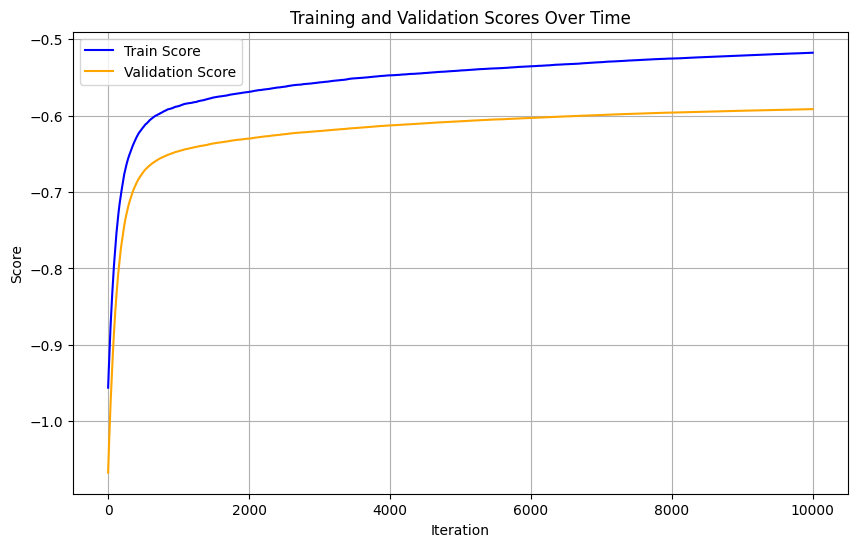

In [ ]:
# Plot the validation score and training score over time
plt.figure(figsize=(10, 6))
plt.plot(fit[1].train_score_, label='Train Score', color='blue')
plt.plot(fit[1].validation_score_, label='Validation Score', color='orange')
plt.xlabel('Iteration')
plt.ylabel('Score')
plt.title('Training and Validation Scores Over Time')
plt.legend()
plt.grid()
plt.show()

In [49]:
fit[0]

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 HistGradientBoostingRegressor(early_stopping=True,
                                               l2_regularization=0.1,
                                               learning_rate=np.float64(0.08935654772874062),
                                               max_depth=np.int64(182),
                                               max_features=np.float64(0.41419759441211),
                                               max_iter=200,
                                               min_samples_leaf=np.int64(76),
                                               scoring='neg_root_mean_squared_error',
                                               validation_fraction=0.2))],
         verbose=True)

In [ ]:
# Fit the model with train data and predict on test data
model = hgbr(
    categorical_features='from_dtype',
    max_iter=5000,
    l2_regularization=best_l2_regularization,
    max_depth=best_max_depth*2,
    learning_rate=best_learning_rate_secondary,
    min_samples_leaf=best_min_samples_leaf,
    max_features=best_max_features,
    early_stopping=True,
    validation_fraction=0.2,
    scoring='neg_root_mean_squared_error',
    verbose=4
)

pipeline = Pipeline([
     ('scaler', StandardScaler()),
     ('model', model)
 ], verbose=True)

fit = pipeline.fit(train_data[Xcols], train_data['qty'])

predictions = fit.predict(test_2015_oct[Xcols])
testresults = test_2015_oct
testresults.index = range(len(testresults))
testresults['item_cnt_month'] = predictions

testresults['item_cnt_month'].clip(0, 20, inplace=True)

testresults['error'] = (testresults['qty']-testresults['item_cnt_month'])
testresults['se']    = (testresults['qty']-testresults['item_cnt_month'])**2
metrics.root_mean_squared_error(testresults['qty'], testresults['item_cnt_month'])

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   6.0s


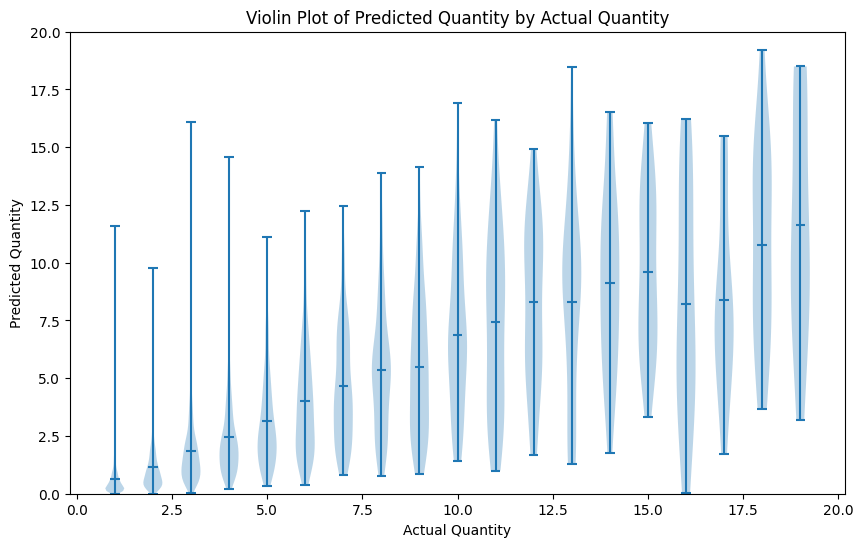

In [ ]:
# Add a violin plot of predicted values for y_test = 1, 2, 3, 4, and 5
plt.figure(figsize=(10, 6))
plt.violinplot([testresults[testresults['qty'] == i]['item_cnt_month'] for i in range(1, 20)], showmeans=True)
plt.xlabel('Actual Quantity')
plt.ylabel('Predicted Quantity')
plt.title('Violin Plot of Predicted Quantity by Actual Quantity')
ax = plt.gca()
ax.set_ylim([0, 20])
plt.show()

In [ ]:
samp_train = shap.utils.sample(train_data[Xcols], 500000)
samp_test = shap.utils.sample(test_2015_oct[Xcols], 500000)

explainer = shap.TreeExplainer(fit[1],samp_train)
shap_values = explainer.shap_values(samp_test)

TypeError: 'HistGradientBoostingRegressor' object is not subscriptable

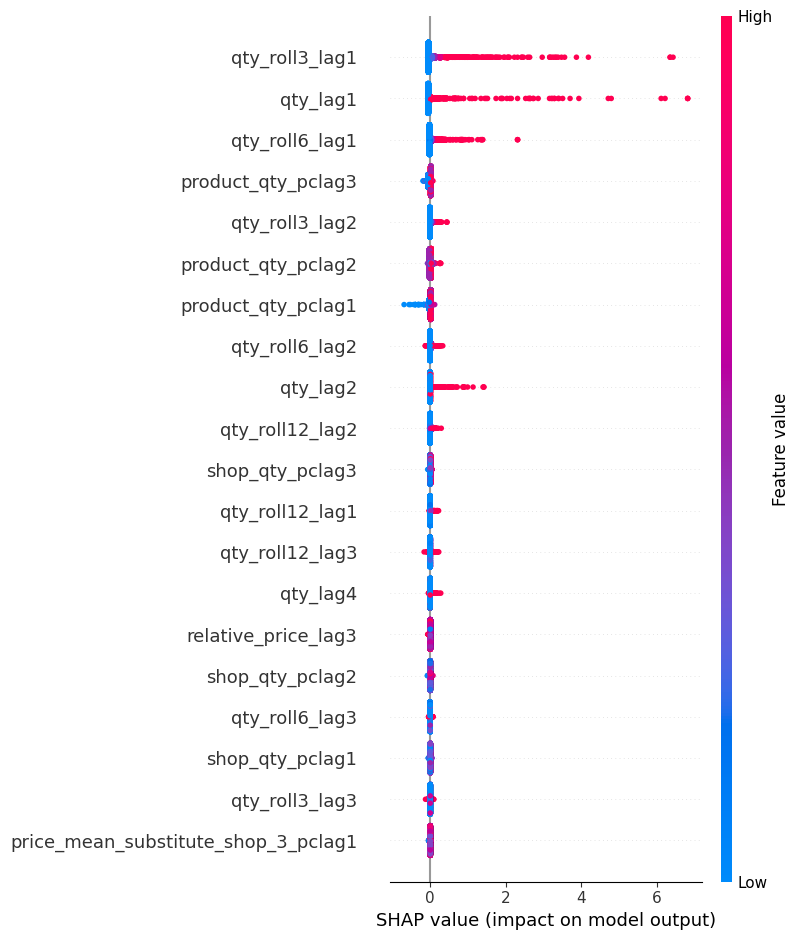

In [ ]:
shap.summary_plot(shap_values,samp_test)